In [4]:
###Import all the softwares we need###

import nni
import numpy as np
import pandas as pd
import torch
import torch.utils.data as Data
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F
import matplotlib.pyplot as plt
import time 
from sklearn.metrics import r2_score

params = {
    'features': 64,
    'lr': 0.002477576440676739,
}

In [5]:
###Import the data and randomly split them for training and testing###

total_data = pd.read_csv("three_port_coupler/FEM_1500.csv") ###This data file is the response of 1500MHz###
total_data = total_data.iloc[:, 2:]
total_data = total_data.dropna(axis=0,how='any') 
total_data = total_data.drop_duplicates()
train_data = total_data.sample(frac=0.8,axis=0,random_state=2)
test_data = pd.concat([total_data, train_data]).drop_duplicates(keep=False)

###Split the data into feature and label###

n_train = train_data.shape[0]
train_features = torch.tensor(train_data.iloc[:, 0:35].values, dtype=torch.float32)
test_features = torch.tensor(test_data.iloc[:, 0:35].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.iloc[:, 35:41].values, dtype=torch.float32)
test_labels  = torch.tensor(test_data.iloc[:, 35:41].values, dtype=torch.float32)

In [6]:
train_data.describe()

,W1(real),W2(real),W3(real),W4(real),W5(real),W6(real),W7(real),W8(real),W9(real),W10(real),...,W32(real),W33(real),W34(real),W35(real),S21R,S21I,S31R,S31I,S32R,S32I
count,32000.000000,32000.000000,32000.0,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,...,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000
mean,0.735938,0.905125,1.0,0.808187,0.523000,0.728781,0.848156,0.852250,0.711344,0.656719,...,0.668656,0.695937,0.664469,0.638437,-0.223456,0.124050,-0.218565,0.146888,-0.233139,-0.336905
std,0.440840,0.293047,0.0,0.393733,0.499479,0.444596,0.358875,0.354858,0.453145,0.474812,...,0.470704,0.460016,0.472183,0.480460,0.233312,0.174956,0.232742,0.179648,0.271500,0.238472
min,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.824900,-0.429800,-0.822200,-0.434400,-0.871000,-0.718200
25%,0.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.407400,-0.001000,-0.402200,0.016200,-0.407100,-0.488200
50%,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,-0.221000,0.127800,-0.214150,0.152400,-0.218600,-0.414050
75%,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,-0.058100,0.251900,-0.051700,0.279900,-0.032175,-0.266975
max,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.594800,0.612700,0.562900,0.657200,0.562000,0.647500


In [7]:
torch_traindata = Data.TensorDataset(train_features, train_labels)
torch_testdata = Data.TensorDataset(test_features, test_labels)
BATCH_SIZE = 128

train_dataloader = Data.DataLoader(
    dataset = torch_traindata,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 2,
)

test_dataloader = Data.DataLoader(
    dataset = torch_testdata,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 2,
)


In [8]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# 训练网络

class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 5, 7)


class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

b1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
                   nn.BatchNorm2d(16), nn.ReLU())

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(16, 16, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(32, 32, 2))
b4 = nn.Sequential(*resnet_block(16, params['features'], 2))

def get_net_forward():
    net = nn.Sequential(Reshape(), b1, nn.Dropout(0), b2, nn.Dropout(0), b4, nn.Dropout(0),
                        nn.AdaptiveAvgPool2d((1,1)),
                        nn.Flatten(), nn.Linear(params['features'], 6))
    return net    
    
model = get_net_forward().to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

Using cuda:1 device


In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
    return loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            R2_value = r2_score(pred.to("cpu"),y.to("cpu"))
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
#     correct /= size
    return test_loss, R2_value

In [10]:
epochs = 100
test_accuracy = []
train_accuracy = []
R2_accuracy = []
time1 = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_accuracy.append(train_loss)
    accuracy,R2_value = test(test_dataloader, model, loss_fn)
    nni.report_intermediate_result(accuracy)
    test_accuracy.append(accuracy)
    R2_accuracy.append(R2_value)
    print(f'Epoch: {t:02d}, Trainloss: {train_loss:.6f}, TestR2: {R2_value:.4f}')
time2 = time.time()
nni.report_final_result(accuracy)

Epoch 1
-------------------------------
[2024-04-01 12:58:09] Intermediate result: 0.007469329990387436  (Index 0)
Epoch: 00, Trainloss: 0.007345, TestR2: 0.3852
Epoch 2
-------------------------------
[2024-04-01 12:58:11] Intermediate result: 0.004379724462827046  (Index 1)
Epoch: 01, Trainloss: 0.004551, TestR2: 0.6137
Epoch 3
-------------------------------
[2024-04-01 12:58:13] Intermediate result: 0.0033231229975908285  (Index 2)
Epoch: 02, Trainloss: 0.003745, TestR2: 0.7436
Epoch 4
-------------------------------
[2024-04-01 12:58:15] Intermediate result: 0.002918458440237575  (Index 3)
Epoch: 03, Trainloss: 0.003297, TestR2: 0.8061
Epoch 5
-------------------------------
[2024-04-01 12:58:17] Intermediate result: 0.002534487321677189  (Index 4)
Epoch: 04, Trainloss: 0.003055, TestR2: 0.8186
Epoch 6
-------------------------------
[2024-04-01 12:58:19] Intermediate result: 0.0024791976606975945  (Index 5)
Epoch: 05, Trainloss: 0.002896, TestR2: 0.8324
Epoch 7
------------------

In [11]:
print("The training time:", round(time2-time1, 2), "s")

The training time: 203.68 s


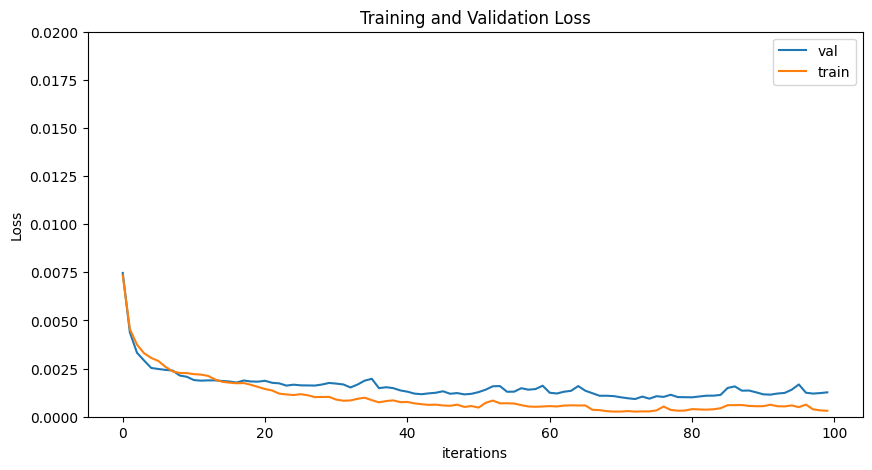

In [12]:
plt.figure(figsize=(10,5))
plt.ylim((0, 0.02))
train_accuracy = torch.tensor(train_accuracy, device = 'cpu')
plt.title("Training and Validation Loss")
plt.plot(test_accuracy,label="val")
plt.plot(train_accuracy,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
R2 = pd.DataFrame(R2_accuracy)
R2.to_csv('ResNet_CNN_R2.csv')

In [14]:
max(R2_accuracy)

0.9217021806866188

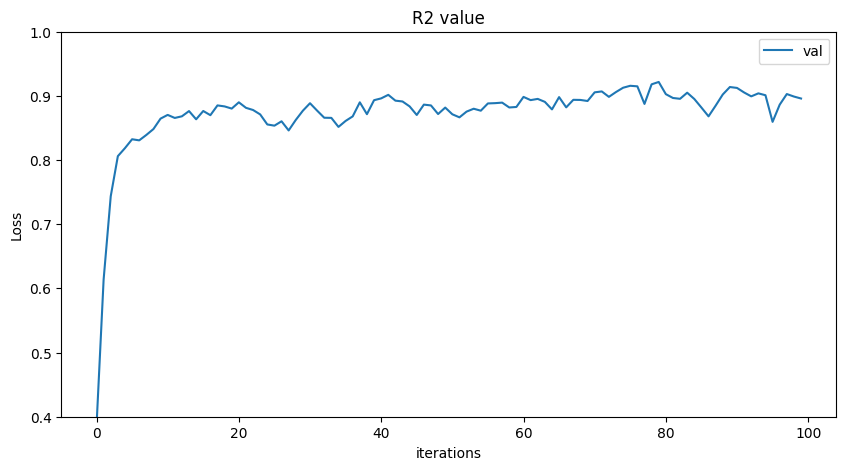

In [15]:
plt.figure(figsize=(10,5))
plt.ylim((0.4, 1))
R2_accuracy = torch.tensor(R2_accuracy, device = 'cpu')
plt.title("R2 value")
plt.plot(R2_accuracy,label="val")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
import torchsummary
torchsummary.summary(model.cuda(0), (1, 35))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Reshape-1              [-1, 1, 5, 7]               0
            Conv2d-2             [-1, 16, 5, 7]             160
       BatchNorm2d-3             [-1, 16, 5, 7]              32
              ReLU-4             [-1, 16, 5, 7]               0
           Dropout-5             [-1, 16, 5, 7]               0
            Conv2d-6             [-1, 16, 5, 7]           2,320
       BatchNorm2d-7             [-1, 16, 5, 7]              32
            Conv2d-8             [-1, 16, 5, 7]           2,320
       BatchNorm2d-9             [-1, 16, 5, 7]              32
         Residual-10             [-1, 16, 5, 7]               0
           Conv2d-11             [-1, 16, 5, 7]           2,320
      BatchNorm2d-12             [-1, 16, 5, 7]              32
           Conv2d-13             [-1, 16, 5, 7]           2,320
      BatchNorm2d-14             [-1, 1

In [17]:
def getModelSize(model):
    param_size = 0
    param_sum = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
        param_sum += param.nelement()
    buffer_size = 0
    buffer_sum = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
        buffer_sum += buffer.nelement()
    all_size = (param_size + buffer_size) / 1024
    print('The model size is：{:.3f}KB'.format(all_size))
    return (param_size, param_sum, buffer_size, buffer_sum, all_size)
    
a, b, c, d, e = getModelSize(model)

The model size is：516.969KB
